In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import os
from sklearn.utils.class_weight import compute_class_weight
import pickle
import importlib
from tensorflow.keras.applications.densenet import preprocess_input


In [2]:
# mount google drive where preprocessed images are
# Mount drive and download data from EDA step 1
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
## create directory in virtual environment
# this takes about 3 mins, please be patient
VDIR_PROJECT = '/content/skin_cancer/training'
os.makedirs(VDIR_PROJECT, exist_ok=True)


# define source directory from Gdrive
GDIR_PROJECT_EDA_S1 = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/EDA_PrePro/S1'

# Copy S1 onto virtual env
#!cp -r {GDIR_PROJECT_EDA_S1}/* {VDIR_PROJECT}

# COPY
S1_ZIP = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/EDA_PrePro/Transformer_Data.zip'
!cp -r {S1_ZIP} {VDIR_PROJECT}

# unzip
!unzip {VDIR_PROJECT}/'Transformer_Data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Transformer Data/Training Data/nv/image_3835.jpg  
  inflating: Transformer Data/Training Data/nv/image_3836.jpg  
  inflating: Transformer Data/Training Data/nv/image_3837.jpg  
  inflating: Transformer Data/Training Data/nv/image_3838.jpg  
  inflating: Transformer Data/Training Data/nv/image_384.jpg  
  inflating: Transformer Data/Training Data/nv/image_3840.jpg  
  inflating: Transformer Data/Training Data/nv/image_3842.jpg  
  inflating: Transformer Data/Training Data/nv/image_3844.jpg  
  inflating: Transformer Data/Training Data/nv/image_3845.jpg  
  inflating: Transformer Data/Training Data/nv/image_3846.jpg  
  inflating: Transformer Data/Training Data/nv/image_3847.jpg  
  inflating: Transformer Data/Training Data/nv/image_3849.jpg  
  inflating: Transformer Data/Training Data/nv/image_385.jpg  
  inflating: Transformer Data/Training Data/nv/image_3851.jpg  
  inflating: Transformer Data/Training Data/nv/image_38

In [6]:
# copy to virtual dir
!mv "/content/Transformer Data"/* {VDIR_PROJECT}

In [7]:
VDIR_PROJECT_VAL = VDIR_PROJECT + "/Validation Data"
VDIR_PROJECT_TRAIN = VDIR_PROJECT + "/Training Data"


In [61]:
# make sure these are consistent with the preprocessing operation
TARGET_SIZE = (224,224)
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS = 50

# create image iterators
# preprocess input according to DenseNet's preprocessing function
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# create train dataset generator
train_generator = datagen.flow_from_directory(
    VDIR_PROJECT_TRAIN,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'categorical',
    seed = RANDOM_SEED)


# create validation dataset generator
val_generator = datagen.flow_from_directory(
    VDIR_PROJECT_VAL,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'categorical',
    seed = RANDOM_SEED)



Found 8864 images belonging to 7 classes.
Found 1094 images belonging to 7 classes.


In [29]:
# Compute class weights
classes = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict



{0: 4.263588263588264,
 1: 2.643602743811512,
 2: 1.2624982196268337,
 3: 11.834445927903872,
 4: 1.1890006706908116,
 5: 0.21892906540209445,
 6: 9.816168327796234}

In [30]:
# Access the class to integer mapping
class_list = train_generator.class_indices

# Print the mapping
print(class_list)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [31]:
# create base classifier model
# Load the DenseNet model with pre-trained weights from ImageNet
input_shape = (TARGET_SIZE[0],TARGET_SIZE[1], 3)
print("input_shape = ", input_shape)
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Use 'softmax' for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

input_shape =  (224, 224, 3)


In [32]:
# print summary
base_model.summary()
model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,094,279 (30.88 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [33]:
# train model
history = model.fit(
    train_generator,
    #steps_per_epoch=len(train_generator),
    class_weight=class_weight_dict,
    validation_data=val_generator,
    #validation_steps=len(val_generator),
    epochs=50, verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - categorical_accuracy: 0.3818 - loss: 1.9851 - val_categorical_accuracy: 0.7751 - val_loss: 0.7428
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - categorical_accuracy: 0.5199 - loss: 1.3820 - val_categorical_accuracy: 0.7724 - val_loss: 0.7820
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - categorical_accuracy: 0.5484 - loss: 1.1432 - val_categorical_accuracy: 0.7925 - val_loss: 0.6961
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - categorical_accuracy: 0.5817 - loss: 1.0261 - val_categorical_accuracy: 0.7907 - val_loss: 0.6540
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - categorical_accuracy: 0.5659 - loss: 1.0579 - val_categorical_accuracy: 0.7358 - val_loss: 0.7370
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - categorical_accuracy: 0.5868 - loss: 1.0114 - val_categorical_accuracy: 0.7651 - val_loss: 0.6993
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - categorical_accuracy: 0.6357 -

In [14]:
# define a function that saves the model weights, training history in the virtual environment
def save_model(TARGET_DIR, model_name="default", model=[], history=[]):
  # check if model exists already to avoid overwriting previous ones
  model_path = TARGET_DIR + '/'+model_name
  if os.path.exists(model_path) and os.path.isdir(model_path):
    print("Folder exists, exiting")
    return
  else:
    print(f"Saving model and training history in :{model_path}")
    os.makedirs(model_path, exist_ok=True)

  model.save(model_path+'/model.keras')
  with open(model_path+'/training_history.pkl', 'wb') as file:
    pickle.dump(history, file)

  return


In [34]:
VDIR_PROJECT_MODELS = VDIR_PROJECT+'/models'
save_model(VDIR_PROJECT_MODELS, "dense121_224x224_noAug", model, history)

Saving model and training history in :/content/skin_cancer/training/models/dense121_224x224_noAug


In [35]:
# Save model to GDRIVE
GDIR_PROJECT_TRAINING = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Training/'
os.makedirs(GDIR_PROJECT_TRAINING, exist_ok=True)

In [36]:
# copy training results from virtual to gdrive
!cp -r {VDIR_PROJECT_MODELS} {GDIR_PROJECT_TRAINING}

In [19]:
# copy evaluation_functions.py from gdrive to current working directory
GDIR_PROJECT_COMMON_FUNCTIONS = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Common_Functions'

!cp -r {GDIR_PROJECT_COMMON_FUNCTIONS}/* ./

In [55]:
import evaluation_functions as ef
importlib.reload(ef)

evaluation_functions version: 0.0.3 is loaded.



<module 'evaluation_functions' from '/content/evaluation_functions.py'>

In [41]:
VDIR_PROJECT_VAL

'/content/skin_cancer/training/Validation Data'

Available Metrics1: ['categorical_accuracy', 'loss']

Here1: metrics: ['categorical_accuracy' 'loss']

Metrics to display: ['categorical_accuracy' 'loss']

Num Rows:  1
plotA 0 train/val curves for metric categorical_accuracy

plotA 1 train/val curves for metric loss



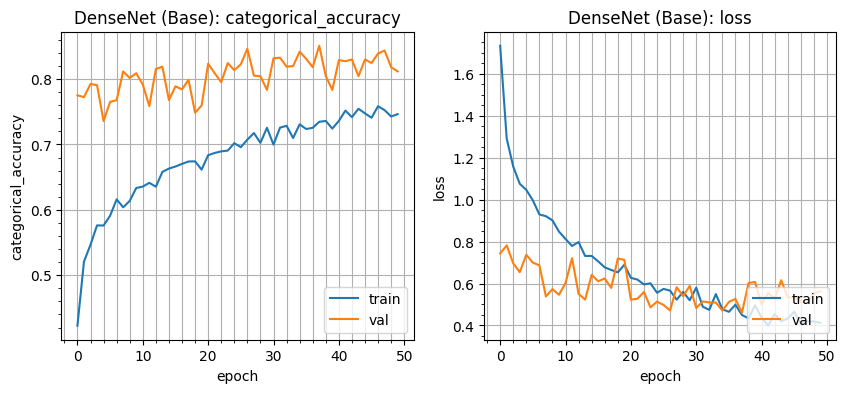

Found 1094 files belonging to 7 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

       akiec       0.27      0.53      0.36        30
         bcc       0.47      0.57      0.51        35
         bkl       0.54      0.62      0.57        86
          df       0.29      0.75      0.41         8
         mel       0.23      0.33      0.27        46
          nv       0.98      0.88      0.93       876
        vasc       0.59      0.77      0.67        13

    accuracy                           0.81      1094
   macro avg       0.48      0.64      0.53      1094
weighted avg       0.87      0.81      0.84      1094



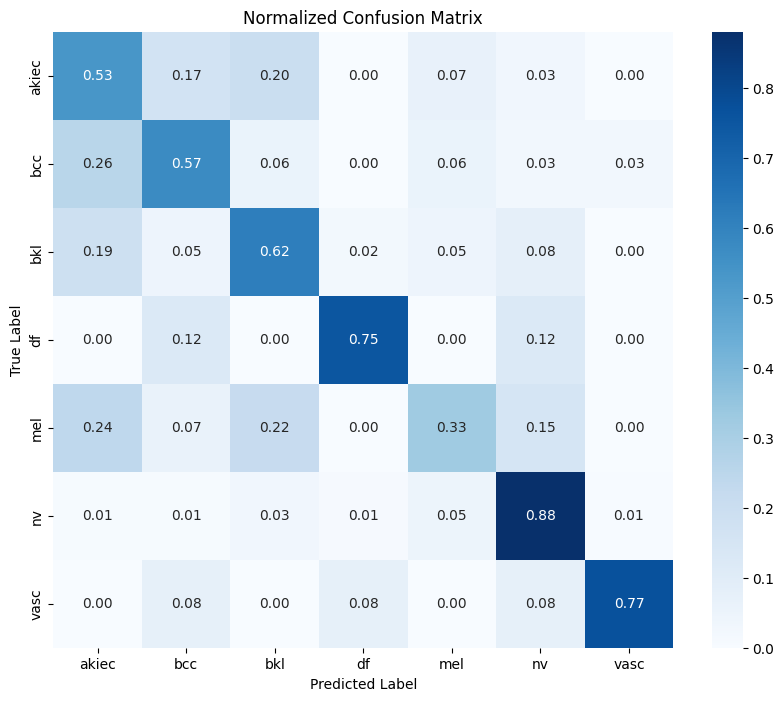

In [56]:
# EVALUATE
ef.group5_evaluate(VDIR_PROJECT_VAL, model=model,
                   model_name="DenseNet (Base)",
                   class_list =class_list,
                   training_history = history,
                   batch_size=256,
                   image_size = (224,224))

In [68]:
# define pipeline function, requires tf
TARGET_SIZE = (224,224)

def fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (TARGET_SIZE[0], TARGET_SIZE[1], 3),
    model_name = 'default',
    DenseNet_model = tf.keras.applications.DenseNet121,
    train_generator = [], # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = [], # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict =[], # class bias during classifier fitting.
    epochs = 50,
    save_dir = [] # where to save model, history
    ):

  #base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
  base_model = DenseNet_model(weights='imagenet', include_top=False, input_shape=target_size)

  # Freeze the base model layers
  base_model.trainable = False

  # Create a classifier model on top of the base model
  model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Use 'softmax' for multi-class classification
  ])

  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

  # print model summary
  base_model.summary()
  model.summary()

  # train model
  history = model.fit(
    train_generator,
    class_weight=class_weight_dict,
    validation_data=val_generator,
    epochs=epochs, verbose=1)

  # save model and history in virtual drive
  save_model(save_dir, model_name, model, history)

  # return model and history history
  return model, history





In [70]:
fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (224,224, 3),
    model_name = 'DenseNet121_v1',
    DenseNet_model = tf.keras.applications.DenseNet121,
    train_generator = train_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = val_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict = class_weight_dict, # class bias during classifier fitting.
    epochs = EPOCHS,
    save_dir = VDIR_PROJECT_MODELS # where to save model, history
    )

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         512,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,553,511 (28.81 MB)

 Trainable params: 516,007 (1.97 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - categorical_accuracy: 0.3429 - loss: 1.9620 - val_categorical_accuracy: 0.6664 - val_loss: 1.0827
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - categorical_accuracy: 0.5023 - loss: 1.3168 - val_categorical_accuracy: 0.7678 - val_loss: 0.7879
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - categorical_accuracy: 0.5515 - loss: 1.1725 - val_categorical_accuracy: 0.7550 - val_loss: 0.6956
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - categorical_accuracy: 0.5512 - loss: 1.1645 - val_categorical_accuracy: 0.6746 - val_loss: 0.8899
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - categorical_accuracy: 0.5728 - loss: 1.0363 - val_categorical_accuracy: 0.7788 - val_loss: 0.6566
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - categorical_accuracy: 0.5935 - loss: 1.0320 - val_categorical_accuracy: 0.7779 - val_loss: 0.6392
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - categorical_accuracy: 0.6000 -

(<Sequential name=sequential_2, built=True>,
 <keras.src.callbacks.history.History at 0x7c56e3adc790>)

In [71]:
fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (224,224, 3),
    model_name = 'DenseNet169_v1',
    DenseNet_model = tf.keras.applications.DenseNet169,
    train_generator = train_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = val_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict = class_weight_dict, # class bias during classifier fitting.
    epochs = EPOCHS,
    save_dir = VDIR_PROJECT_MODELS # where to save model, history
    )

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 230, 230, 3)    │              0 │ input_layer_6[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 7, 7, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │         832,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,478,887 (51.42 MB)

 Trainable params: 836,007 (3.19 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 68s 133ms/step - categorical_accuracy: 0.3529 - loss: 1.9656 - val_categorical_accuracy: 0.7176 - val_loss: 0.9101
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - categorical_accuracy: 0.5257 - loss: 1.2909 - val_categorical_accuracy: 0.5823 - val_loss: 1.1124
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - categorical_accuracy: 0.5703 - loss: 1.0910 - val_categorical_accuracy: 0.8090 - val_loss: 0.5778
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - categorical_accuracy: 0.5795 - loss: 1.0388 - val_categorical_accuracy: 0.8199 - val_loss: 0.5343
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - categorical_accuracy: 0.5882 - loss: 0.9921 - val_categorical_accuracy: 0.7660 - val_loss: 0.6982
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - categorical_accuracy: 0.6056 - loss: 0.9534 - val_categorical_accuracy: 0.7697 - val_loss: 0.6339
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - categorical_accurac

(<Sequential name=sequential_3, built=True>,
 <keras.src.callbacks.history.History at 0x7c56acf70e50>)

In [72]:
fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (224,224, 3),
    model_name = 'DenseNet201_v1',
    DenseNet_model = tf.keras.applications.DenseNet201,
    train_generator = train_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = val_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict = class_weight_dict, # class bias during classifier fitting.
    epochs = EPOCHS,
    save_dir = VDIR_PROJECT_MODELS # where to save model, history
    )

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_9[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │         960,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,285,991 (73.57 MB)

 Trainable params: 964,007 (3.68 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 79s 151ms/step - categorical_accuracy: 0.3412 - loss: 2.0372 - val_categorical_accuracy: 0.7980 - val_loss: 0.6761
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - categorical_accuracy: 0.5338 - loss: 1.2452 - val_categorical_accuracy: 0.7687 - val_loss: 0.7300
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - categorical_accuracy: 0.5780 - loss: 1.0611 - val_categorical_accuracy: 0.7194 - val_loss: 0.7681
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - categorical_accuracy: 0.5881 - loss: 0.9788 - val_categorical_accuracy: 0.7514 - val_loss: 0.6917
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - categorical_accuracy: 0.6201 - loss: 0.8911 - val_categorical_accuracy: 0.7276 - val_loss: 0.7170
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - categorical_accuracy: 0.6242 - loss: 0.8990 - val_categorical_accuracy: 0.7998 - val_loss: 0.5683
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - categorical_accurac

(<Sequential name=sequential_4, built=True>,
 <keras.src.callbacks.history.History at 0x7c56876b28f0>)

In [74]:
# copy training results from virtual to gdrive
!cp -r {VDIR_PROJECT_MODELS} {GDIR_PROJECT_TRAINING}